## Importing the libraries

In [2]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [3]:
import torchvision.transforms.functional as tf
import pandas as pd
import os
import numpy as np
from skimage.util import view_as_windows
from skimage import io
import PIL
from glob import glob
import matplotlib.pyplot as plt
import warnings
import cv2
from skimage.metrics import structural_similarity

warnings.filterwarnings('ignore')

### Patch Extraction Utility Functions

In [5]:
def check_and_reshape(image, input_mask):
    """
    Gets an image reshapes it and returns it with its mask.
    :param image: The image
    :param input_mask: The mask of the image
    :returns: the image and its mask
    """
    try:
        mask_x, mask_y = input_mask.shape
        mask = np.empty((mask_x, mask_y, 3))
        mask[:, :, 0] = input_mask
        mask[:, :, 1] = input_mask
        mask[:, :, 2] = input_mask
    except ValueError:
        mask = input_mask
    if image.shape == mask.shape:
        return image, mask
    elif image.shape[0] == mask.shape[1] and image.shape[1] == mask.shape[0]:
        mask = np.reshape(mask, (image.shape[0], image.shape[1], mask.shape[2]))
        return image, mask
    else:
        return image,mask

In [6]:
def extract_all_patches(image, window_shape, stride, num_of_patches, rotations, output_path, im_name, rep_num, mode):
    """
    Extracts all the patches from an image.
    :param image: The image
    :param window_shape: The shape of the window (for example (128,128,3) in the CASIA2 dataset)
    :param stride: The stride of the patch extraction
    :param num_of_patches: The amount of patches to be extracted per image
    :param rotations: The amount of rotations divided equally in 360 degrees
    :param output_path: The output path where the patches will be saved
    :param im_name: The name of the image
    :param rep_num: The amount of repetitions
    :param mode: If we account rotations 'rot' or nor 'no_rot'
    """
    non_tampered_windows = view_as_windows(image, window_shape, step=stride)
    non_tampered_patches = []
    for m in range(non_tampered_windows.shape[0]):
        for n in range(non_tampered_windows.shape[1]):
            non_tampered_patches += [non_tampered_windows[m][n][0]]
    # select random some patches, rotate and save them
    save_patches(non_tampered_patches, num_of_patches, mode, rotations, output_path, im_name, rep_num,
                 patch_type='authentic')

In [7]:
def delete_prev_images(dir_name):
    """
    Deletes all the file in a directory.
    :param dir_name: Directory name
    """
    for the_file in os.listdir(dir_name):
        file_path = os.path.join(dir_name, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)

In [8]:
def create_dirs(output_path):
    """
    Creates the directories to the output path.
    :param output_path: The output path
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        os.makedirs(output_path + '/authentic')
        os.makedirs(output_path + '/tampered')
    else:
        if os.path.exists(output_path + '/authentic'):
            delete_prev_images(output_path + '/authentic')
        else:
            os.makedirs(output_path + '/authentic')
        if os.path.exists(output_path + '/tampered'):
            delete_prev_images(output_path + '/tampered')
        else:
            os.makedirs(output_path + '/tampered')

In [9]:
def save_patches(patches, num_of_patches, mode, rotations, output_path, im_name, rep_num, patch_type):
    """
    Saves all the extracted patches to the output path.
    :param patches: The extracted patches
    :param num_of_patches: The amount of patches to be extracted per image
    :param mode: If we account rotations 'rot' or nor 'no_rot'
    :param rotations: The amount of rotations divided equally in 360 degrees
    :param output_path: The output path where the patches will be saved
    :param im_name: The name of the image
    :param rep_num: The amount of repetitions
    :param patch_type: The mask of the image
    """
    inds = np.random.choice(len(patches), num_of_patches, replace=False)
    if mode == 'rot':
        for i, ind in enumerate(inds):
            image = patches[ind][0] if patch_type == 'tampered' else patches[ind]
            for angle in rotations:
                im_rt = tf.rotate(PIL.Image.fromarray(np.uint8(image)), angle=angle,
                                  resample=PIL.Image.BILINEAR)
                im_rt.save(output_path + '/{0}/{1}_{2}_{3}_{4}.png'.format(patch_type, im_name, i, angle, rep_num))
    else:
        for i, ind in enumerate(inds):
            image = patches[ind][0] if patch_type == 'tampered' else patches[ind]
            io.imsave(output_path + '/{0}/{1}_{2}_{3}.png'.format(patch_type, im_name, i, rep_num), image)

In [10]:
def find_tampered_patches(image, im_name, mask, window_shape, stride, dataset, patches_per_image):
    """
    Gets an image reshapes it and returns it with its mask.
    :param image: The image
    :param im_name: The name of the image
    :param mask: The mask of the image
    :param window_shape: The shape of the window (for example (128,128,3) in the CASIA2 dataset)
    :param stride: The stride of the patch extraction
    :param dataset: The name of the dataset
    :param patches_per_image: The amount of patches to be extracted per image
    :returns: the tampered patches and their amount
    """
    # extract patches from images and masks
    patches = view_as_windows(image, window_shape, step=stride)

    if dataset == 'casia2':
        mask_patches = view_as_windows(mask, window_shape, step=stride)
    elif dataset == 'nc16':
        mask_patches = view_as_windows(mask, (128, 128), step=stride)
    else:
        raise NotSupportedDataset('The datasets supported are casia2 and nc16')

    tampered_patches = []
    # find tampered patches
    for m in range(patches.shape[0]):
        for n in range(patches.shape[1]):
            im = patches[m][n][0]
            ma = mask_patches[m][n][0]
            num_zeros = (ma == 0).sum()
            num_ones = (ma == 255).sum()
            total = num_ones + num_zeros
            if dataset == 'casia2':
                if num_zeros <= 0.99 * total:
                    tampered_patches += [(im, ma)]
            elif dataset == 'nc16':
                if 0.80 * total >= num_ones >= 0.20 * total:
                    tampered_patches += [(im, ma)]

    # if patches are less than the given number then take the minimum possible
    num_of_patches = patches_per_image
    if len(tampered_patches) < num_of_patches:
        print("Number of tampered patches for image {} is only {}".format(im_name, len(tampered_patches)))
        num_of_patches = len(tampered_patches)

    return tampered_patches, num_of_patches

## Patch Extractor Class for CASIA 2 Dataset

In [15]:
class PatchExtractorCASIA:
    """
    Patch extraction class
    """

    def __init__(self, input_path, output_path, patches_per_image=4, rotations=8, stride=8, mode='no_rot'):
        """
        Initialize class
        :param patches_per_image: Number of samples to extract for each image
        :param rotations: Number of rotations to perform
        :param stride: Stride size to be used
        """
        self.patches_per_image = patches_per_image
        self.stride = stride
        rots = [0, 90, 180, 270]
        self.rotations = rots[:rotations]
        self.mode = mode
        self.input_path = input_path
        self.output_path = output_path

        # define the indices of the image names and read the authentic images
        self.background_index = [13, 21]
        au_index = [3, 6, 7, 12]
        au_pic_list = glob(self.input_path + os.sep + 'Au' + os.sep + '*')
        self.au_pic_dict = {
            au_pic.split(os.sep)[-1][au_index[0]:au_index[1]] + au_pic.split(os.sep)[-1][au_index[2]:au_index[3]]:
                au_pic for au_pic
            in au_pic_list}

    def extract_authentic_patches(self, sp_pic, num_of_patches, rep_num):
        """
        Extracts and saves the patches from the authentic image
        :param sp_pic: Name of tampered image
        :param num_of_patches: Number of patches to be extracted
        :param rep_num: Number of repetitions being done(just for the patch name)
        """
        sp_name = sp_pic.split('/')[-1][self.background_index[0]:self.background_index[1]]
        if sp_name in self.au_pic_dict.keys():
            au_name = self.au_pic_dict[sp_name].split(os.sep)[-1].split('.')[0]
            # define window size
            window_shape = (128, 128, 3)
            au_pic = self.au_pic_dict[sp_name]
            au_image = plt.imread(au_pic)
            # extract all patches
            extract_all_patches(au_image, window_shape, self.stride, num_of_patches, self.rotations, self.output_path,
                                au_name, rep_num, self.mode)

    def extract_patches(self):
        """
        Main function which extracts all patches
        :return:
        """
        # uncomment to extract masks
#         mask_path = 'masks'
#         if os.path.exists(mask_path) and os.path.isdir(mask_path):
#             if not os.listdir(mask_path):
#                 print("Extracting masks")
#                 extract_masks()
#                 print("Masks extracted")
#             else:
#                 print("Masks exist. Patch extraction begins...")
#         else:
#             os.makedirs(mask_path)
#             print("Extracting masks")
#             extract_masks()
#             print("Masks extracted")
#         #

        # create necessary directories
        create_dirs(self.output_path)

        # define window shape
        window_shape = (128, 128, 3)
        tp_dir = self.input_path+'/Tp/'
        rep_num = 0
        # run for all the tampered images
        for f in os.listdir(tp_dir):
            try:
                if f == 'Thumbs.db' or f == '_list.txt':
                    continue
                rep_num += 1
                image = io.imread(tp_dir + f)
                im_name = f.split(os.sep)[-1].split('.')[0]
                # read mask
                mask = io.imread(self.input_path + '/CASIA2.0_Groundtruth/' + im_name + '_gt.png')

                image, mask = check_and_reshape(image, mask)

                # extract patches from images and masks
                tampered_patches, num_of_patches = find_tampered_patches(image, im_name, mask,
                                                                         window_shape, self.stride, 'casia2',
                                                                         self.patches_per_image)
                save_patches(tampered_patches, num_of_patches, self.mode, self.rotations, self.output_path, im_name,
                             rep_num, patch_type='tampered')
                self.extract_authentic_patches(tp_dir + f, num_of_patches, rep_num)
            except IOError as e:
                rep_num -= 1
                print(str(e))
            except IndexError:
                rep_num -= 1
                print('Mask and image have not the same dimensions')

## Patch Extraction Driver Code (CASIA Dataset)

In [ ]:
pe = PatchExtractorCASIA(input_path='/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised', output_path='patches_casia_with_rot',
                         patches_per_image=2, stride=128, rotations=4)
pe.extract_patches()

Number of tampered patches for image Tp_S_NRD_S_B_arc00053_arc00053_01073 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_arc00049_arc00049_01077 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_art00086_art00086_01011 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_ind20058_ind20058_02301 is only 0
Number of tampered patches for image Tp_S_NRD_S_B_ind00051_ind00051_00902 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_ind00038_ind00038_01329 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_arc20089_arc20089_02413 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_arc20059_arc20059_01699 is only 0
Number of tampered patches for image Tp_S_NRD_S_B_art10106_art10106_11589 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_art00089_art00089_01009 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_ind20035_ind20035_02288 is only 1
Number of tampered patches for image Tp_S_NRD_S_B_cha00100_cha00100_00875 is

## Training the CNN model

### Filters

In [ ]:
from typing import Dict

import numpy as np
from torch import Tensor, stack


def get_filters():
    """
    Function that return the required high pass SRM filters for the first convolutional layer of our implementation
    :return: A pytorch Tensor containing the 30x3x5x5 filter tensor with type
    [number_of_filters, input_channels, height, width]
    """

    filters: Dict[str, Tensor] = {}

    # 1st Order
    filters["1O1"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["1O2"] = Tensor(np.rot90(filters["1O1"]).copy())
    filters["1O3"] = Tensor(np.rot90(filters["1O2"]).copy())
    filters["1O4"] = Tensor(np.rot90(filters["1O3"]).copy())
    filters["1O5"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, -1, 0, 0], [0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["1O6"] = Tensor(np.rot90(filters["1O5"]).copy())
    filters["1O7"] = Tensor(np.rot90(filters["1O6"]).copy())
    filters["1O8"] = Tensor(np.rot90(filters["1O7"]).copy())
    # 2nd Order
    filters["2O1"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, -2, 1, 0], [0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["2O2"] = Tensor(np.rot90(filters["2O1"]).copy())
    filters["2O3"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, 1, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["2O4"] = Tensor(np.rot90(filters["2O3"]).copy())
    # 3rd Order
    filters["3O1"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, -3, 1, 0], [0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["3O2"] = Tensor(np.rot90(filters["3O1"]).copy())
    filters["3O3"] = Tensor(np.rot90(filters["3O2"]).copy())
    filters["3O4"] = Tensor(np.rot90(filters["3O3"]).copy())
    filters["3O5"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [0, 0, -3, 0, 0], [0, 1, 0, 0, 0],
                                      [0, 0, 0, 0, 0]]))
    filters["3O6"] = Tensor(np.rot90(filters["3O5"]).copy())
    filters["3O7"] = Tensor(np.rot90(filters["3O6"]).copy())
    filters["3O8"] = Tensor(np.rot90(filters["3O7"]).copy())
    # 3x3 SQUARE
    filters["3x3S"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, -1, 2, -1, 0], [0, 2, -4, 2, 0], [0, -1, 2, -1, 0],
                                       [0, 0, 0, 0, 0]]))
    # 3x3 EDGE
    filters["3x3E1"] = Tensor(np.array([[0, 0, 0, 0, 0], [0, -1, 2, -1, 0], [0, 2, -4, 2, 0], [0, 0, 0, 0, 0],
                                        [0, 0, 0, 0, 0]]))
    filters["3x3E2"] = Tensor(np.rot90(filters["3x3E1"]).copy())
    filters["3x3E3"] = Tensor(np.rot90(filters["3x3E2"]).copy())
    filters["3x3E4"] = Tensor(np.rot90(filters["3x3E3"]).copy())
    # 5X5 EDGE
    filters["5x5E1"] = Tensor(np.array([[-1, 2, -2, 2, -1], [2, -6, 8, -6, 2], [-2, 8, -12, 8, -2],
                                        [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]))
    filters["5x5E2"] = Tensor(np.rot90(filters["5x5E1"]).copy())
    filters["5x5E3"] = Tensor(np.rot90(filters["5x5E2"]).copy())
    filters["5x5E4"] = Tensor(np.rot90(filters["5x5E3"]).copy())
    # 5x5 SQUARE
    filters["5x5S"] = Tensor(np.array([[-1, 2, -2, 2, -1], [2, -6, 8, -6, 2], [-2, 8, -12, 8, -2],
                                       [2, -6, 8, -6, 2], [-1, 2, -2, 2, -1]]))

    return vectorize_filters(filters)


def vectorize_filters(filters: dict):
    """
    Function that takes as input the 30x5x5 different SRM high pass filters and creates the 30x3x5x5 tensor with the
    following permutations 𝑾𝑗 = [𝑊3𝑘−2 𝑊3𝑘−1 𝑊3𝑘] where 𝑘 = ((𝑗 − 1) mod 10) + 1 and (𝑗 = 1, ⋅ ⋅ ⋅ , 30).
    :arg filters: The 30 SRM high pass filters
    :return: Returns the 30x3x5x5 filter tensor of the type [number_of_filters, input_channels, height, width]
    """
    tensor_list = []

    w = list(filters.values())

    for i in range(1, 31):
        tmp = []

        k = ((i - 1) % 10) + 1

        tmp.append(w[3 * k - 3])
        tmp.append(w[3 * k - 2])
        tmp.append(w[3 * k - 1])

        tensor_list.append(stack(tmp))

    return stack(tensor_list)


### CNN Class

In [ ]:
import torch.nn.functional as f
import torch.nn as nn


class CNN(nn.Module):
    """
    The convolutional neural network (CNN) class
    """
    def __init__(self):
        """
        Initialization of all the layers in the network.
        """
        super(CNN, self).__init__()

        self.conv0 = nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv0.weight)

        self.conv1 = nn.Conv2d(3, 30, kernel_size=5, stride=2, padding=0)
        self.conv1.weight = nn.Parameter(get_filters())

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(30, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv2.weight)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv3.weight)

        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv4.weight)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv5 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv5.weight)

        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv6.weight)

        self.conv7 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv7.weight)

        self.conv8 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv8.weight)

        self.fc = nn.Linear(16 * 5 * 5, 2)

        self.drop1 = nn.Dropout(p=0.5)  # used only for the NC dataset

    def forward(self, x):
        """
        The forward step of the network that consumes an image patch and either uses a fully connected layer in the
        training phase with a softmax or just returns the feature map after the final convolutional layer.
        :returns: Either the output of the softmax during training or the 400-D feature representation at testing
        """
        x = f.relu(self.conv0(x))
        x = f.relu(self.conv1(x))
        lrn = nn.LocalResponseNorm(3)
        x = lrn(x)
        x = self.pool1(x)
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = f.relu(self.conv5(x))
        x = lrn(x)
        x = self.pool2(x)
        x = f.relu(self.conv6(x))
        x = f.relu(self.conv7(x))
        x = f.relu(self.conv8(x))
        x = x.view(-1, 16 * 5 * 5)

        # In the training phase we also need the fully connected layer with softmax
        if self.training:
            # x = self.drop1(x) # used only for the NC dataset
            x = f.relu(self.fc(x))
            x = f.softmax(x, dim=1)

        return x


### Script to train the CNN model

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import time
import numpy as np


def create_loss_and_optimizer(net, learning_rate=0.01):
    """
    Creates the loss function and optimizer of the network.
    :param net: The network object
    :param learning_rate: The initial learning rate
    :returns: The loss function and the optimizer
    """
    loss = nn.CrossEntropyLoss()
    optimizer = optim.ADAM(net.parameters(), lr=learning_rate, momentum=0.99, weight_decay=5 * 1e-4)
    return loss, optimizer


def train_net(net, train_set, n_epochs, learning_rate, batch_size):
    """
    Training of the CNN
    :param net: The CNN object
    :param train_set: The training part of the dataset
    :param n_epochs: The number of epochs of the experiment
    :param learning_rate: The initial learning rate
    :param batch_size: The batch size of the ADAM
    :returns: The epoch loss (vector) and the epoch accuracy (vector)
    """
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    criterion, optimizer = create_loss_and_optimizer(net, learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
    n_batches = len(train_loader)
    epoch_loss = []
    epoch_accuracy = []

    for epoch in range(n_epochs):

        total_running_loss = 0.0
        print_every = n_batches // 5
        training_start_time = time.time()
        c = 0
        total_predicted = []
        total_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            # get the inputs
            if torch.cuda.is_available():
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda().long())
            else:
                inputs = Variable(inputs)
                labels = Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)

            total_labels.extend(labels)
            total_predicted.extend(predicted)

            if (i + 1) % (print_every + 1) == 0:
                total_running_loss += loss.item()
                c += 1

        epoch_predictions = (np.array(total_predicted) == np.array(total_labels)).sum().item()
        print('---------- Epoch %d Loss: %.3f Accuracy: %.3f Time: %.3f----------' % (
            epoch + 1, total_running_loss / c, epoch_predictions / len(total_predicted),
            time.time() - training_start_time))
        epoch_accuracy.append(epoch_predictions / len(total_predicted))
        epoch_loss.append(total_running_loss / c)
        scheduler.step()

    print('Finished Training')

    return epoch_loss, epoch_accuracy


### train_net.py -> Driver code for training the CNN model

In [ ]:
import torch
import pandas as pd
import torchvision.transforms as transforms
from torchvision import datasets


torch.manual_seed(0)

DATA_DIR = "patches_casia_with_rot"  # the directory of the augmented patches
transform = transforms.Compose([transforms.ToTensor()])

data = datasets.ImageFolder(root=DATA_DIR, transform=transform)  # Fetch data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if str(device) == "cuda:0":
    print("cuda enabled")
    cnn = CNN().cuda()
else:
    print("no cuda")
    cnn = CNN()

epoch_loss, epoch_accuracy = train_net(cnn, data, n_epochs=40, learning_rate=0.0001, batch_size=128)

pd.DataFrame(epoch_loss).to_csv('SRM_loss.csv')
pd.DataFrame(epoch_accuracy).to_csv('SRM_accuracy.csv')

torch.save(cnn.state_dict(), 'Cnn.pt')


## Feature Extraction

### Feature Fusion

In [ ]:
import math

import torch
import numpy as np


def get_yi(model, patch):
    """
    Returns the patch's feature representation
    :param model: The pre-trained CNN object
    :param patch: The patch
    :returns: The 400-D feature representation of the patch
    """
    with torch.no_grad():
        model.eval()
        return model(patch)


class WrongOperationOption(Exception):
    pass


def get_y_hat(y: np.ndarray, operation: str):
    """
    Fuses the image's patches feature representation
    :param y: The network object
    :param operation: Either max or mean for the pooling operation
    :returns: The final 400-D feature representation of the entire image
    """
    if operation == "max":
        return np.array(y).max(axis=0, initial=-math.inf)
    elif operation == "mean":
        return np.array(y).mean(axis=0)
    else:
        raise WrongOperationOption("The operation can be either mean or max")


### Feature Vector Generation

In [ ]:
import torchvision.transforms as transforms
from torch.autograd import Variable


def create_feature_vectors(model, tampered_path, authentic_path, output_name):
    """
    Writes the feature vectors of the CASIA2 dataset.
    :param model: The pre-trained CNN object
    :param tampered_path: The path of the tampered images of the CASIA2 dataset
    :param authentic_path: The path of the authentic images of the CASIA2 dataset
    :param output_name: The name of the output CSV that contains the feature vectors
    """
    df = pd.DataFrame()
    images = get_images_and_labels(tampered_path, authentic_path)
    c = 1
    for image_name in images.keys():  # images
        print("Image: ", c)

        image = images[image_name]['mat']
#         if c >= 4966:
#             print(image)

        label = images[image_name]['label']
        if image is not None:
            df = pd.concat([df, pd.concat([pd.DataFrame([image_name.split(os.sep)[-1], str(label)]),
                                           pd.DataFrame(get_patch_yi(model, image))])], axis=1, sort=False)
        c += 1

    # save the feature vector to csv
    final_df = df.T
    final_df.columns = get_df_column_names()
    final_df.to_csv(output_name, index=False)  # csv type [im_name][label][f1,f2,...,fK]


def create_feature_vectors_nc(model, input_path, output_name):
    """
    Writes the feature vectors of the NC 2016 dataset.
    :param model: The pre-trained CNN object
    :param input_path: The path of the dataset
    :param output_name: The name of the output CSV that contains the feature vectors
    """
    df = pd.DataFrame()
    images = get_images_and_labels_nc()
    c = 1
    for image_name, label in images.items():  # images

        print("Image: ", c)
#         if c >= 4966:
#             print(image)
        if image_name == 'Thumbs.db':
            continue

        image = io.imread(input_path + image_name)
        if image is not None:
            df = pd.concat([df, pd.concat([pd.DataFrame([image_name, str(label)]),
                                       pd.DataFrame(get_patch_yi(model, image))])], axis=1, sort=False)
        c += 1

    # save the feature vector to csv
    final_df = df.T
    final_df.columns = get_df_column_names()
    final_df.to_csv(output_name, index=False)  # csv type [im_name][label][f1,f2,...,fK]


def get_patch_yi(model, image):
    """
    Calculates the feature representation of an image.
    :param model: The pre-trained CNN object
    :param image: The image
    :returns: The image's feature representation
    """
    transform = transforms.Compose([transforms.ToTensor()])

    y = []  # init Y

    patches = get_patches(image, stride=1024)

    for patch in patches:  # for every patch
        img_tensor = transform(patch)
        img_tensor.unsqueeze_(0)
        img_variable = Variable(img_tensor.double())
        yi = get_yi(model=model, patch=img_variable)
        y.append(yi)  # append Yi to Y

    y = np.vstack(tuple(y))

    y_hat = get_y_hat(y=y, operation="mean")  # create Y_hat with mean or max

    return y_hat


def get_df_column_names():
    """
    Rename the feature csv column names as [im_names][labels][f1,f2,...,fK].
    :returns: The column names
    """
    names = ["image_names", "labels"]
    for i in range(400):
        names.append("f" + str(i + 1))
    return names


### patch_extraction.py

In [ ]:
import glob
import cv2
from skimage.util import view_as_windows


def get_patches(image_mat, stride):
    """
    Extract patches rom an image
    :param image_mat: The image as a matrix
    :param stride: The stride of the patch extraction process
    :returns: The patches
    """
    window_shape = (128, 128, 3)
    #print(image_mat)
    patches = []

    image_map_nparray = np.array(image_mat)
    #print(len(image_mat), 'x', len(image_mat[0]), 'x', len(image_mat[0][0]))
    image_map_nparray.reshape(len(image_mat), len(image_mat[0]), len(image_mat[0][0]))
    windows = view_as_windows(image_map_nparray, window_shape, step=stride)

    for m in range(windows.shape[0]):
        for n in range(windows.shape[1]):
            patches += [windows[m][n][0]]
    return patches


def get_images_and_labels(tampered_path, authentic_path):
    """
    Get the images and their corresponding labels
    :param tampered_path: The path containing the tampered images
    :param authentic_path: The path containing the authentic images
    :returns: Dictionary with images and labels
    """
    tampered_dir = tampered_path
    authentic_dir = authentic_path
    images = {}
    for im in glob.glob(authentic_dir):
        images[im] = {}
        images[im]['mat'] = cv2.imread(im)
        images[im]['label'] = 0
    for im in glob.glob(tampered_dir):
        images[im] = {}
        images[im]['mat'] = cv2.imread(im)
        images[im]['label'] = 1
    return images


def get_images_and_labels_nc():
    """
    Get the images and their corresponding labels for the NC 2016 dataset
    :returns: Dictionary with images and labels
    """
    refs = get_ref_df()
    images = {}
    for _, data in refs.iterrows():
        if data['ProbeFileName'] in images:
            continue
        im = data['ProbeFileName']
        images[im] = 1 if data['IsTarget'] == 'Y' else 0
    return images


### Feature Extraction Driver Code

In [ ]:
import torch


with torch.no_grad():
    model = CNN()
    model.load_state_dict(torch.load('../input/pretrained-cnn/CASIA2_WithRot_LR001_b128_nodrop.pt',
                                     map_location=lambda storage, loc: storage))
    model.eval()
    model = model.double()

    authentic_path = '../input/casia-20-image-tampering-detection-dataset/CASIA2/Au/*'
    tampered_path = '../input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/*'
    output_filename = 'CASIA2_WithRot_LR001_b128_nodrop.csv'
    create_feature_vectors(model, tampered_path, authentic_path, output_filename)


## SVM Classification

### SVM.py

In [ ]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import seaborn as sn


def optimize_hyperparams(x, y, params):
    """
    Hyperparameter optimization of the SVM
    :param x: The feature vectors
    :param y: The labels
    :param params: The grid of all the possible optimal hyperparameters
    :returns: The optimal hyperparameters
    """
    # Optimize hyper-parameters
    model = svm.SVC(probability=True)
    model_grid_search = GridSearchCV(model, params, cv=10, n_jobs=5)
    model_grid_search.fit(x.values, y.values)
    print("Optimal hyper-parameters: ", model_grid_search.best_params_)
    print("Accuracy :", model_grid_search.best_score_)
    return model_grid_search.best_params_


def classify(x, y, opt_params):
    """
    Classify a feature vector using SVM and print some metrics
    :param x: The feature vectors
    :param y: The labels
    :param opt_params: The optimal hyperparameters
    """
    # Single SVM run with optimized hyperparameters and
    model = svm.SVC(kernel='rbf', gamma=opt_params['gamma'], C=opt_params['C'], probability=True)
    scores = cross_val_score(model, x, y, cv=10, scoring='accuracy', n_jobs=-1)
    print(scores)
    print(np.mean(scores))
    print(np.std(scores))


def print_confusion_matrix(x, y, opt_params):
    """
    Print the confusion matrix of an SVM classification
    :param x: The feature vectors
    :param y: The labels
    :param opt_params: The optimal hyperparameters
    """
    y_pred, y_test = get_predictions(x, y, opt_params)
    # Printing out false/true positives/negatives
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('True negatives: ', tn, 'False positives: ', fp, 'False negatives: ', fn, 'True positives: ', tp)

    # Using seaborn to create a confusion matrix table
    data = {'y_Predicted': y_pred, 'y_Actual': y_test}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(conf_matrix, cmap=ListedColormap(['#ED7D31', '#009FDA']), annot=True, fmt='g', cbar=False)


def find_misclassified(x, y, opt_params, img_ids):
    """
    Gets the misclassified image ids and writes them to a csv
    :param x: The feature vectors
    :param y: The labels
    :param opt_params: The optimal hyperparameters
    :param img_ids: The image ids that correspond to the feature vector(x)
    """
    y_pred, y_test = get_predictions(x, y, opt_params)
    misclassified = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test.values[i]:
            misclassified.append(str(y_pred[i]) + ',' + str(y_test.values[i]) + ',' + str(img_ids[y_test.index[i]]))
    df = pd.DataFrame(misclassified)
    df.columns = ['Prediction,Actual,ImageName']
    df.to_csv('Misclassified.csv', index=False)


def get_predictions(x, y, opt_params):
    """
    Classification using SVM
    :param x: The feature vectors
    :param y: The labels
    :param opt_params: The optimal hyperparameters
    :returns: The predicted and true labels
    """
    # Run one SVM with 80-20 split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)
    model = svm.SVC(kernel='rbf', gamma=opt_params['gamma'], C=opt_params['C'], probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return y_pred, y_test


### svm_classification.py (Driver for SVM Classifier)

Has NaN: False
Optimal hyper-parameters:  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy : 0.9269073044686944
[0.92234548 0.92472266 0.92709984 0.92472266 0.92466297 0.92942109
 0.93180016 0.92862807 0.92942109 0.92624901]
0.9269073044686944
0.002745948978858654
True negatives:  1397 False positives:  101 False negatives:  70 True positives:  955


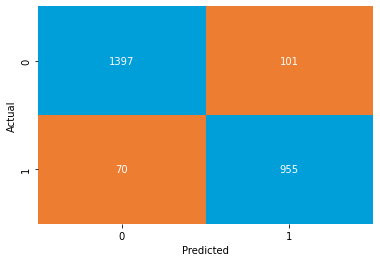

In [ ]:
import pandas as pd

# Read features and labels from CSV
df = pd.read_csv(filepath_or_buffer='./CASIA2_WithRot_LR001_b128_nodrop.csv')
X = df.loc[:, ~df.columns.isin(['labels', 'image_names'])]
y = df['labels']

img_ids = df['image_names']

print('Has NaN:', df.isnull().values.any())

hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

opt_params = optimize_hyperparams(X, y, params=hyper_params)
classify(X, y, opt_params)
print_confusion_matrix(X, y, opt_params)
find_misclassified(X, y, opt_params, img_ids)


## Training Accuracy and Training Loss Graph

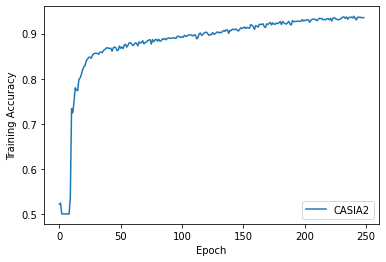

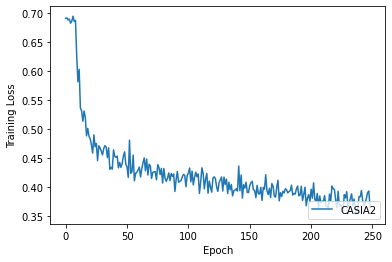

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_epochs(metric1, ylab, metric2=None):
    """
    Plot the metrics of both datasets
    :param metric1: The first metric that we want to plot
    :param metric2: The second metric that we want to plot
    :param ylab: The label of the y axis
    """
    plt.plot(metric1, label='CASIA2')
#     plt.plot(metric2, label='NC16')
    plt.ylabel(ylab)
    plt.xlabel("Epoch")
    plt.legend(loc='lower right')
    plt.show()


if __name__ == "__main__":
    df1 = pd.read_csv(filepath_or_buffer="../input/accuracy-loss/CASIA2_WithRot_LR001_b128_nodrop_Accuracy.csv")
#     df2 = pd.read_csv(filepath_or_buffer="../../data/output/accuracy/NC16_WithRot_LR001_b128_withdrop_Accuracy.csv")
    df3 = pd.read_csv(filepath_or_buffer="../input/accuracy-loss/CASIA2_WithRot_LR001_b128_nodrop_Loss.csv")
#     df4 = pd.read_csv(filepath_or_buffer="../../data/output/loss_function/NC16_WithRot_LR001_b128_withdrop_Loss.csv")
#     plot_epochs(df1.iloc[:, 1], df2.iloc[:, 1], 'Training Accuracy')
    plot_epochs(df1.iloc[:, 1], 'Training Accuracy')
#     plot_epochs(df3.iloc[:, 1], df4.iloc[:, 1], 'Training Loss')
    plot_epochs(df3.iloc[:, 1], 'Training Loss')


## Testing a sample Image

In [ ]:
from joblib import load
import torch
from cv2 import imread
import numpy as np

import warnings
warnings.filterwarnings("ignore")


def get_feature_vector(image_path: str, model):
    feature_vector = np.empty((1, 400))
    feature_vector[0, :] = get_patch_yi(model, imread(image_path))
    return feature_vector


# Load the pretrained CNN with the CASIA2 dataset
with torch.no_grad():
    our_cnn = CNN()
    our_cnn.load_state_dict(torch.load('../input/pretrained-cnn/CASIA2_WithRot_LR001_b128_nodrop.pt',
                                       map_location=lambda storage, loc: storage))
    our_cnn.eval()
    our_cnn = our_cnn.double()

# Load the pretrained svm model
svm_model = load('../input/pretrained-svm/CASIA2_WithRot_LR001_b128_nodrop.pt')

print("Labels are 0 for non-tampered and 1 for tampered")

# Probe the SVM model with a non-tampered image
non_tampered_image_path = '../input/testimages/Au_ani_00002.jpg'
non_tampered_image_feature_vector = get_feature_vector(non_tampered_image_path, our_cnn)
#print("Non tampered image feature vector: ", non_tampered_image_feature_vector)
prediction_svm = svm_model.predict(non_tampered_image_feature_vector)
print("Non tampered prediction:", prediction_svm)
# print("Confidence: ", svm_model.predict_proba())
# Probe the SVM model with a tampered image
tampered_image_path = '../input/testimages/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'
tampered_image_feature_vector = get_feature_vector(tampered_image_path, our_cnn)
#print("Tampered image feature vector: ", tampered_image_feature_vector)
prediction_svm = svm_model.predict(tampered_image_feature_vector)
print("Tampered prediction: ", prediction_svm)
# print("Confidence: ", predict_proba())


Labels are 0 for non-tampered and 1 for tampered
Non tampered prediction: [0]
Tampered prediction:  [1]


## CASIA Test Dataset (50 Authentic and 50 Tampered Images)

In [ ]:
import os
from os import listdir

# get the path or directory
test_folder_dir = ""

print("CASIA Test dataset: 50 authentic & 50 tampered images")
print("Labels are 0 for non-tampered and 1 for tampered")

count_not_tampered, count_tampered = 0, 0

for images in os.listdir(test_folder_dir):

    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg")\
        or images.endswith(".jpeg") or images.endswith(".tif")):
        test_image_path = test_folder_dir + '/' + images
        test_image_feature_vector = get_feature_vector(test_image_path, our_cnn)
        #print("Tampered image feature vector: ", tampered_image_feature_vector)
        prediction_svm = svm_model.predict(test_image_feature_vector)
        print("Image name: ", images)
        print("Tampered prediction: ", prediction_svm[0])
        if(prediction_svm[0] == 1):
            count_tampered += 1
        else:
            count_not_tampered += 1

print("No of authentic images: ", count_not_tampered)
print("No of tampered images: ", count_tampered)


CASIA Test dataset: 50 authentic & 50 tampered images
Labels are 0 for non-tampered and 1 for tampered
Image name:  Au_sec_30319.jpg
Tampered prediction:  1
Image name:  Au_sec_30296.jpg
Tampered prediction:  0
Image name:  Tp_D_NRN_S_N_nat00059_ani00070_11414.jpg
Tampered prediction:  1
Image name:  Au_sec_30323.jpg
Tampered prediction:  0
Image name:  Tp_D_NRN_S_N_nat00097_ani00017_11412.jpg
Tampered prediction:  1
Image name:  Tp_D_CNN_M_N_nat10156_ani00024_12016.jpg
Tampered prediction:  1
Image name:  Tp_D_NRN_S_N_nat00059_ani00005_11415.jpg
Tampered prediction:  1
Image name:  Au_sec_30287.jpg
Tampered prediction:  0
Image name:  Au_sec_30294.jpg
Tampered prediction:  0
Image name:  Tp_D_NRN_S_N_nat10139_ani00058_11951.jpg
Tampered prediction:  1
Image name:  Au_sec_30321.jpg
Tampered prediction:  0
Image name:  Au_sec_30295.jpg
Tampered prediction:  0
Image name:  Tp_D_CNN_M_N_ind00091_ind00091_10647.jpg
Tampered prediction:  1
Image name:  Au_sec_30303.jpg
Tampered prediction: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Conclusion:

The CNN approach is seen to be very efficient with the CASIA dataset, where the iamge tampering were not very challenging (Splicing in specific). The CNN's accuracy for the CASIA dataset is 92.69 %.
